In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'HUN'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,2951,-2502,449,-34,860,1665,2025,5039,122,...,1275,0,267,2332,4860,9168,417,-250,246.0,2015-02-21
1,2015-03-31,2589,-2139,450,17,994,1633,1869,4887,119,...,1191,0,529,2474,4835,9184,34,-149,245.0,2015-05-02
2,2015-06-30,2740,-2191,549,41,599,1721,1938,4595,119,...,1209,0,127,2122,4927,8948,147,-147,245.0,2015-08-01
3,2015-09-30,2638,-2165,473,63,433,1596,1850,4251,117,...,1068,0,158,2065,4716,8663,206,-158,245.0,2015-11-01
4,2015-12-31,2332,-1956,376,9,257,1420,1692,3834,116,...,1061,0,170,1917,4626,8406,188,-209,245.0,2016-02-21


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-12-31,2024-02-21,177.0,1403,-1251,152,-57,540,747,867,...,387,7248,719,0,12,1172,1676,4025,164,-83
37,2024-03-31,2024-04-29,171.8,1470,-1269,201,-16,552,837,896,...,378,7577,745,0,396,1574,1660,4174,-62,-42
38,2024-06-30,2024-08-05,172.8,1574,-1331,243,31,335,877,923,...,366,7317,708,0,369,1729,1344,3981,54,-50
39,2024-09-30,2024-11-04,172.1,1540,-1306,234,-5,330,822,1004,...,358,7334,726,0,346,1560,1513,3989,118,-41
40,2024-12-31,2025-02-17,172.1,1452,-1264,188,-110,340,725,917,...,344,7114,758,0,325,1565,1510,3951,175,-51


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-21,177.0,1403,-1251,152,-57,540,747,867,...,7248,719,0,12,1172,1676,4025,164,-83,1
37,2024-03-31,2024-04-29,171.8,1470,-1269,201,-16,552,837,896,...,7577,745,0,396,1574,1660,4174,-62,-42,1
38,2024-06-30,2024-08-05,172.8,1574,-1331,243,31,335,877,923,...,7317,708,0,369,1729,1344,3981,54,-50,1
39,2024-09-30,2024-11-04,172.1,1540,-1306,234,-5,330,822,1004,...,7334,726,0,346,1560,1513,3989,118,-41,1
40,2024-12-31,2025-02-17,172.1,1452,-1264,188,-110,340,725,917,...,7114,758,0,325,1565,1510,3951,175,-51,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-21,177.0,1403.0,-1251.0,152.0,-57.0,540.0,747.0,867.0,...,7248.0,719.0,0.0,12.0,1172.0,1676.0,4025.0,164.0,-83.0,1
37,2024-03-31,2024-04-29,171.8,1470.0,-1269.0,201.0,-16.0,552.0,837.0,896.0,...,7577.0,745.0,0.0,396.0,1574.0,1660.0,4174.0,-62.0,-42.0,1
38,2024-06-30,2024-08-05,172.8,1574.0,-1331.0,243.0,31.0,335.0,877.0,923.0,...,7317.0,708.0,0.0,369.0,1729.0,1344.0,3981.0,54.0,-50.0,1
39,2024-09-30,2024-11-04,172.1,1540.0,-1306.0,234.0,-5.0,330.0,822.0,1004.0,...,7334.0,726.0,0.0,346.0,1560.0,1513.0,3989.0,118.0,-41.0,1
40,2024-12-31,2025-02-17,172.1,1452.0,-1264.0,188.0,-110.0,340.0,725.0,917.0,...,7114.0,758.0,0.0,325.0,1565.0,1510.0,3951.0,175.0,-51.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-02-23,16.305592,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.16067,0.83933,0.0,0.0,0.0,0.0,0.152152,-0.011522,0.0,0.0
1,2015-03-02,15.565087,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.16067,0.83933,0.0,0.0,0.0,0.0,0.152152,-0.011522,0.0,0.0
2,2015-03-09,15.790143,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.16067,0.83933,0.0,0.0,0.0,0.0,0.152152,-0.011522,0.0,0.0
3,2015-03-16,15.698540,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.16067,0.83933,0.0,0.0,0.0,0.0,0.152152,-0.011522,0.0,0.0
4,2015-03-23,15.523303,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.16067,0.83933,0.0,0.0,0.0,0.0,0.152152,-0.011522,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-02-23,16.305592,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.0,0.152152,-0.011522,0.0,0.0,inf,2.285570,inf,inf,inf
1,2015-03-02,15.565087,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.0,0.152152,-0.011522,0.0,0.0,inf,2.181773,inf,inf,inf
2,2015-03-09,15.790143,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.0,0.152152,-0.011522,0.0,0.0,inf,2.213319,inf,inf,inf
3,2015-03-16,15.698540,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.0,0.152152,-0.011522,0.0,0.0,inf,2.200479,inf,inf,inf
4,2015-03-23,15.523303,2014-12-31,2951.0,0.0,7.134146,246.0,0.0,0.0,860.0,...,0.0,0.152152,-0.011522,0.0,0.0,inf,2.175916,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

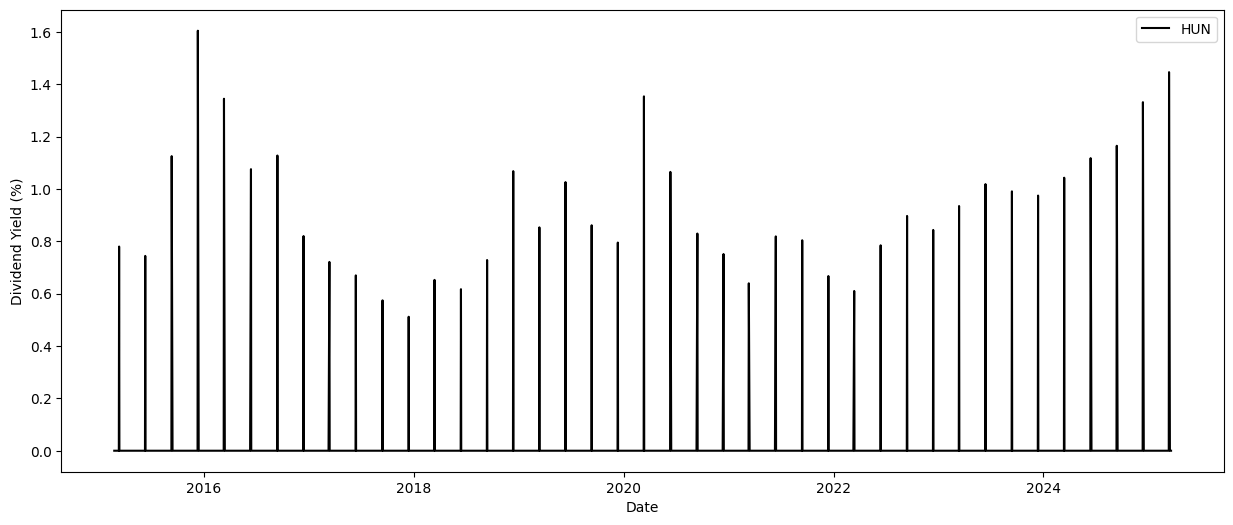

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


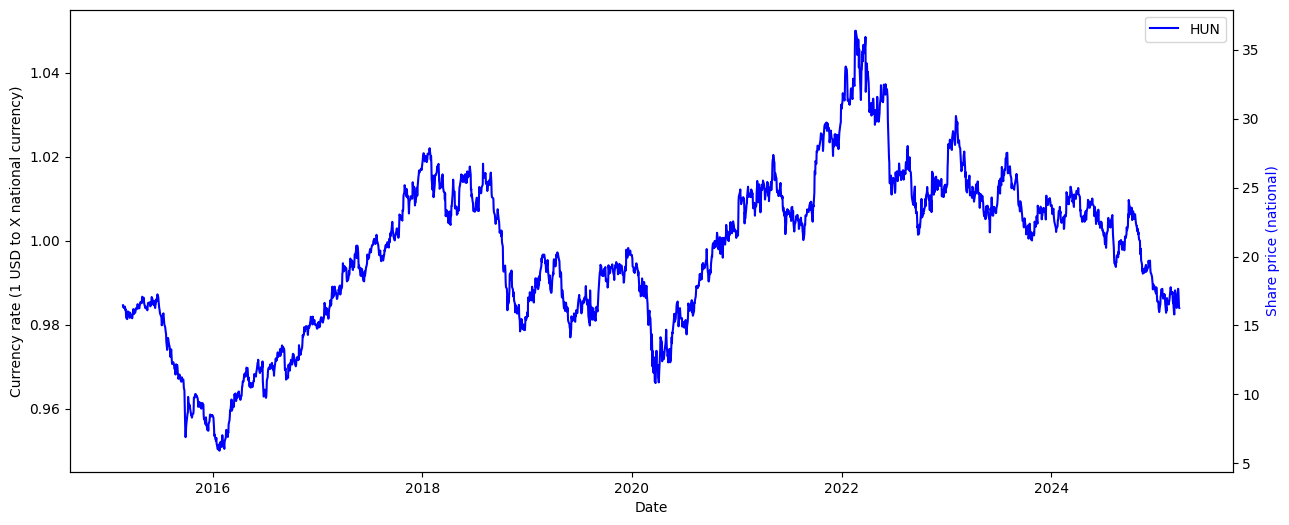

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

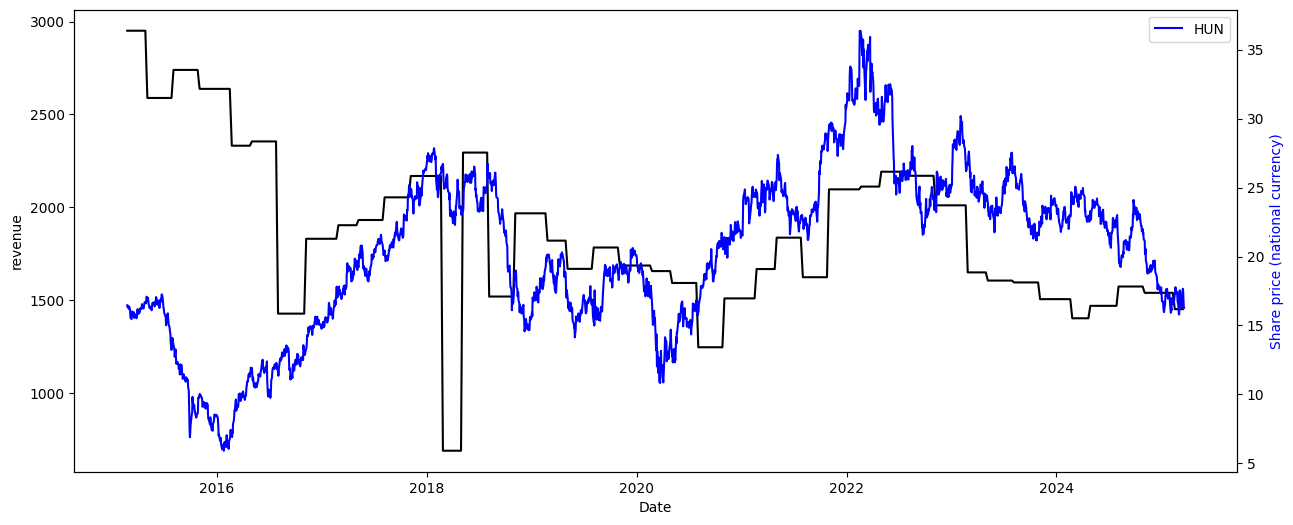

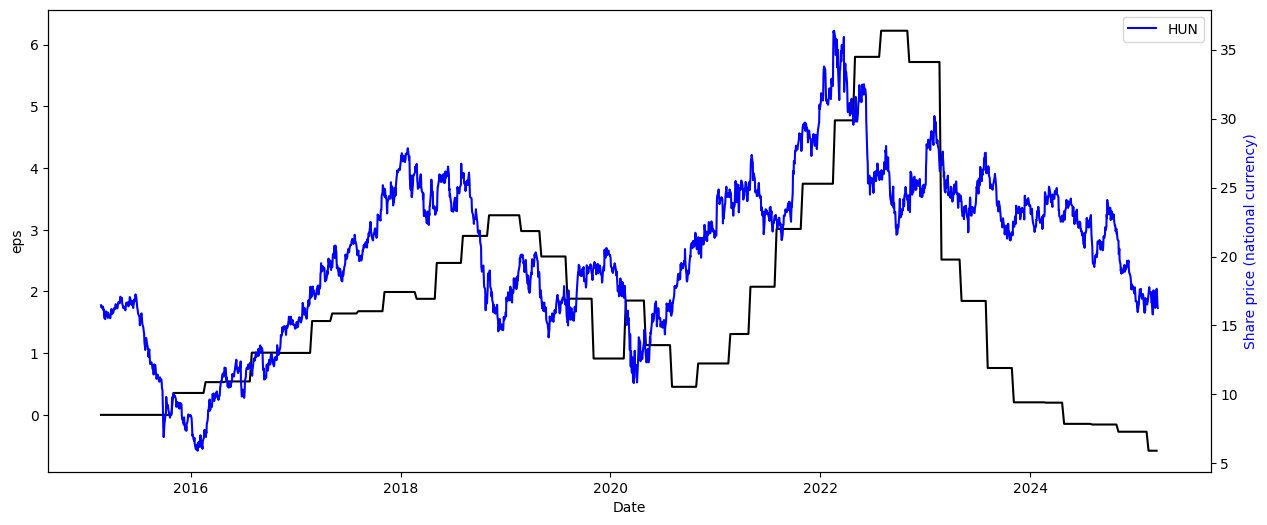

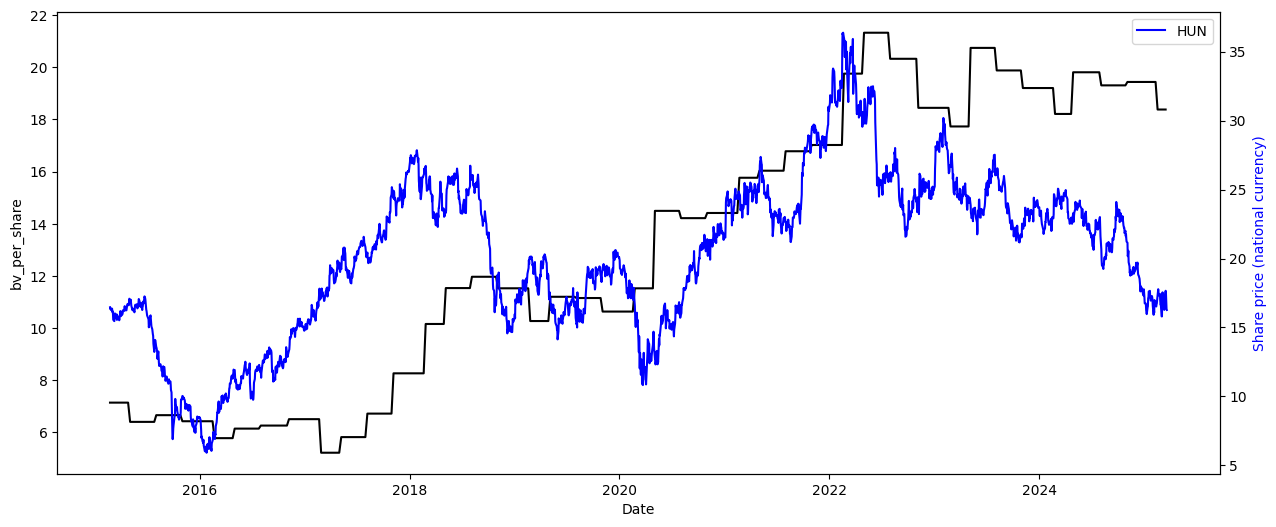

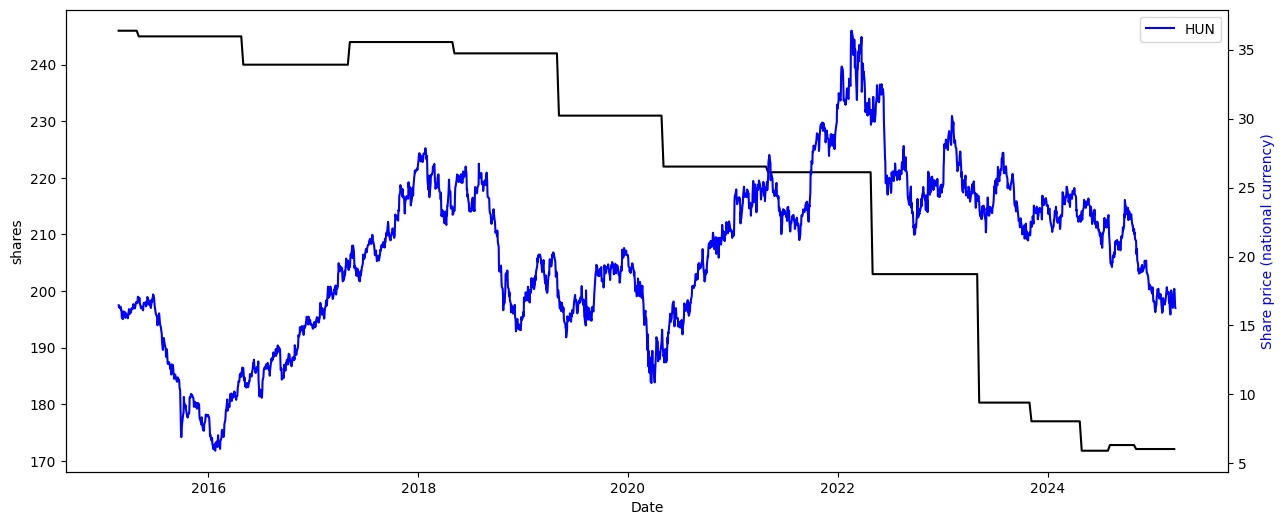

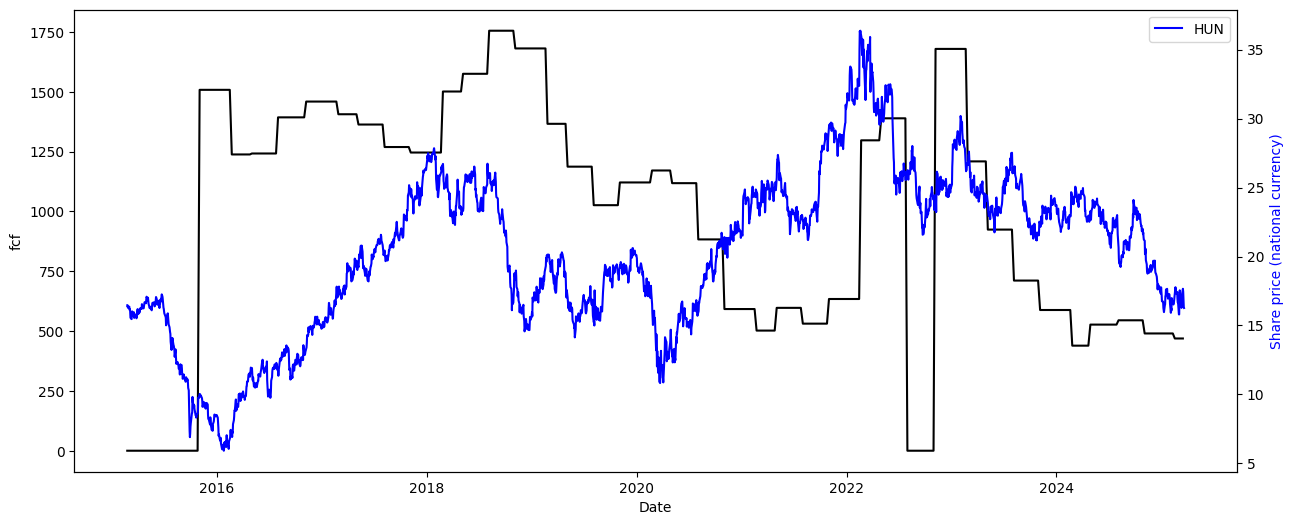

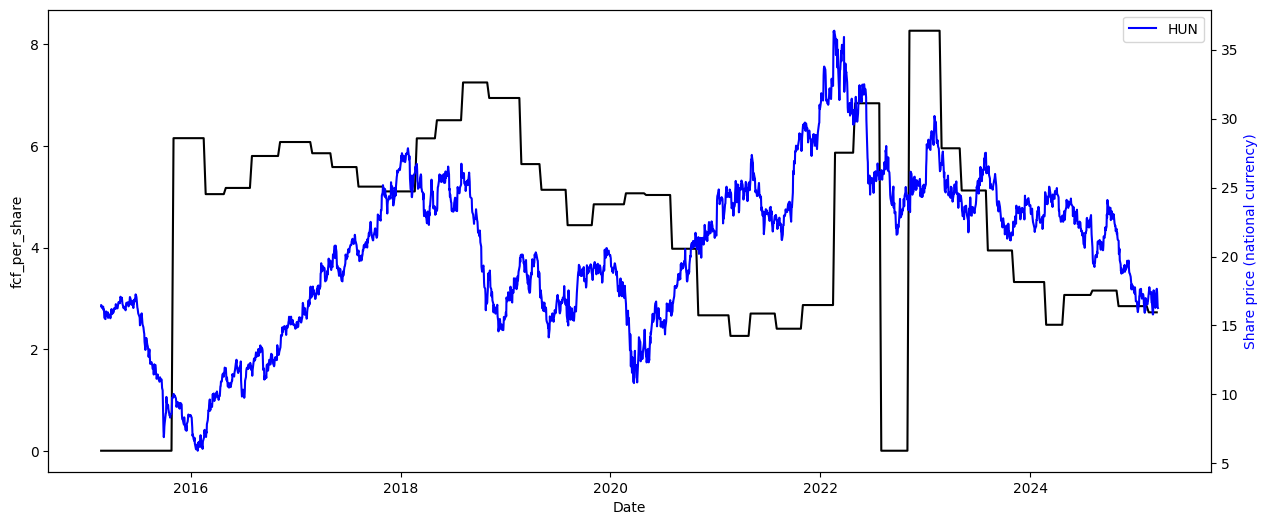

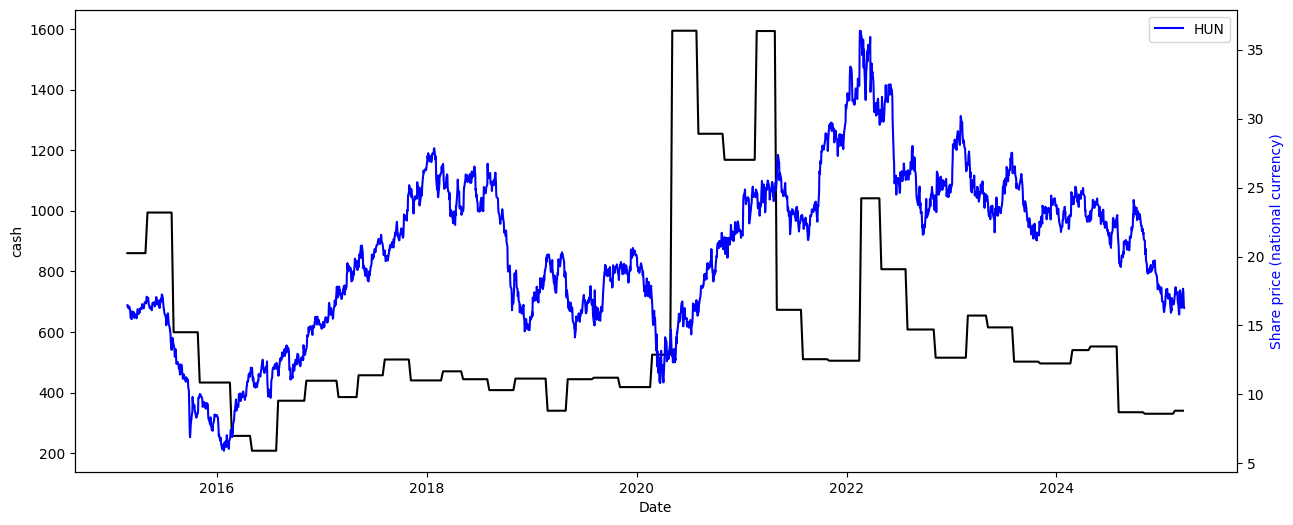

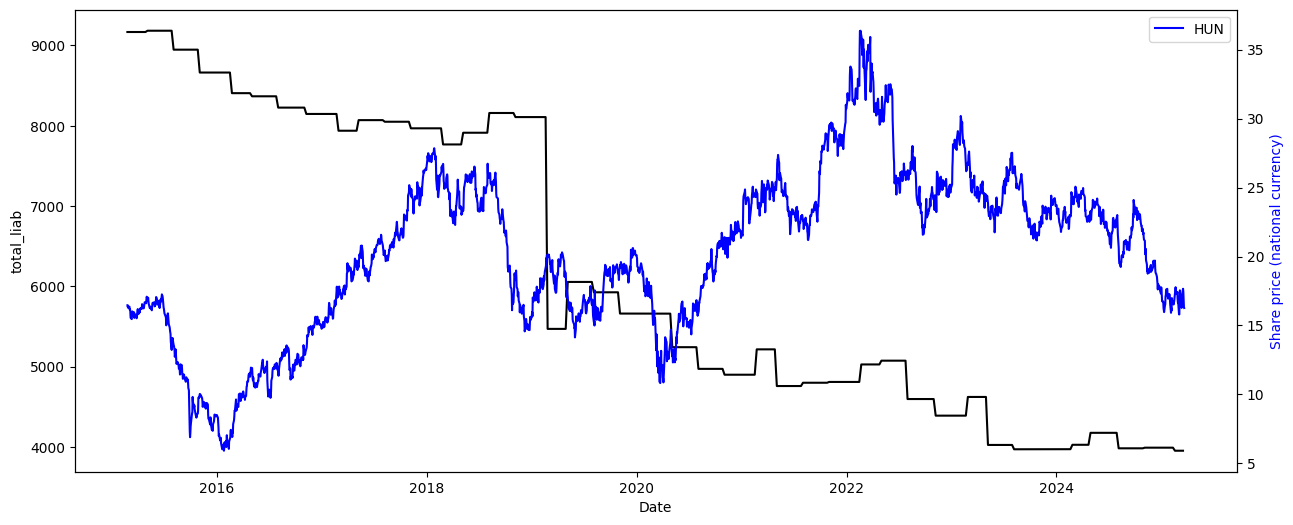

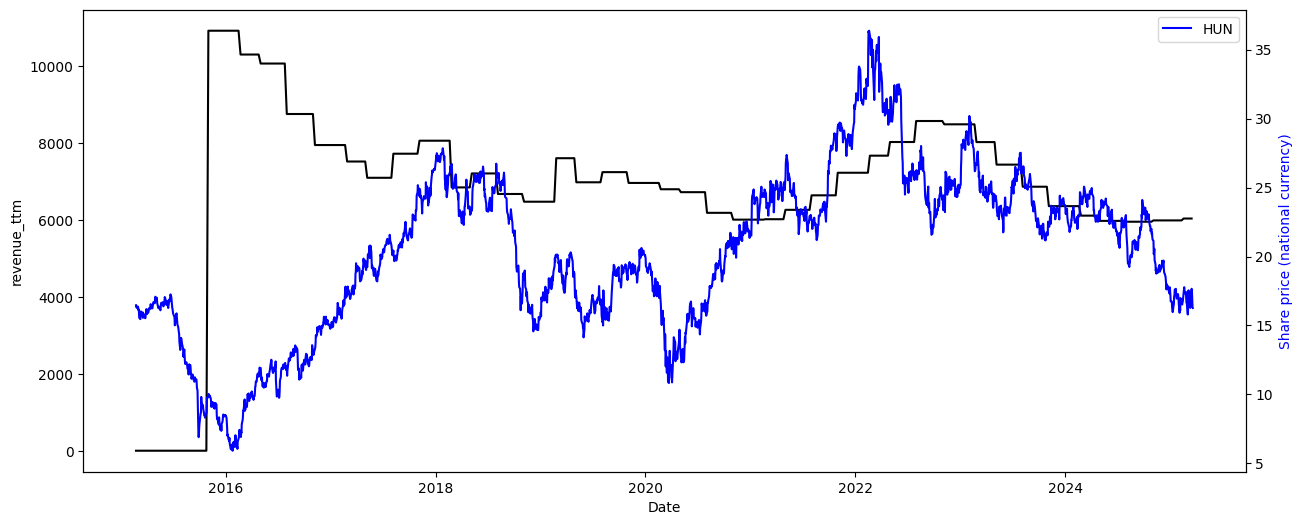

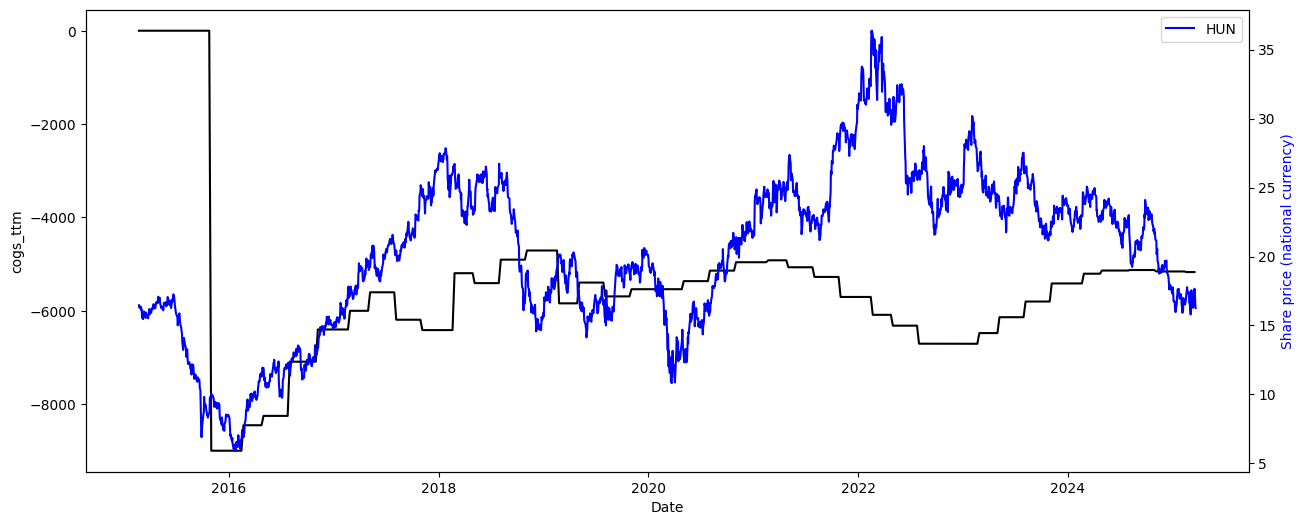

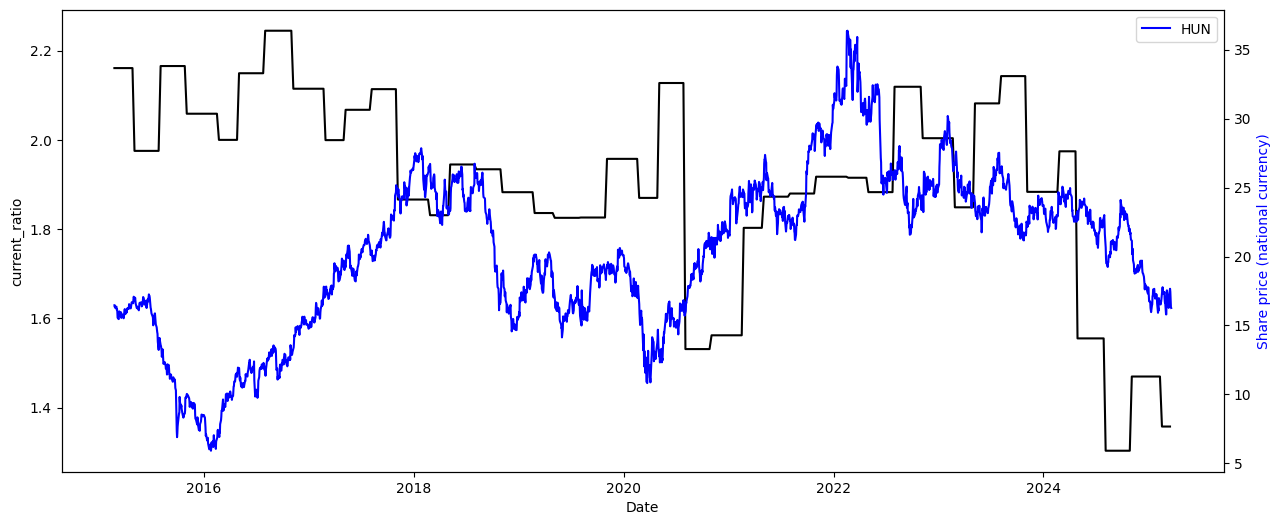

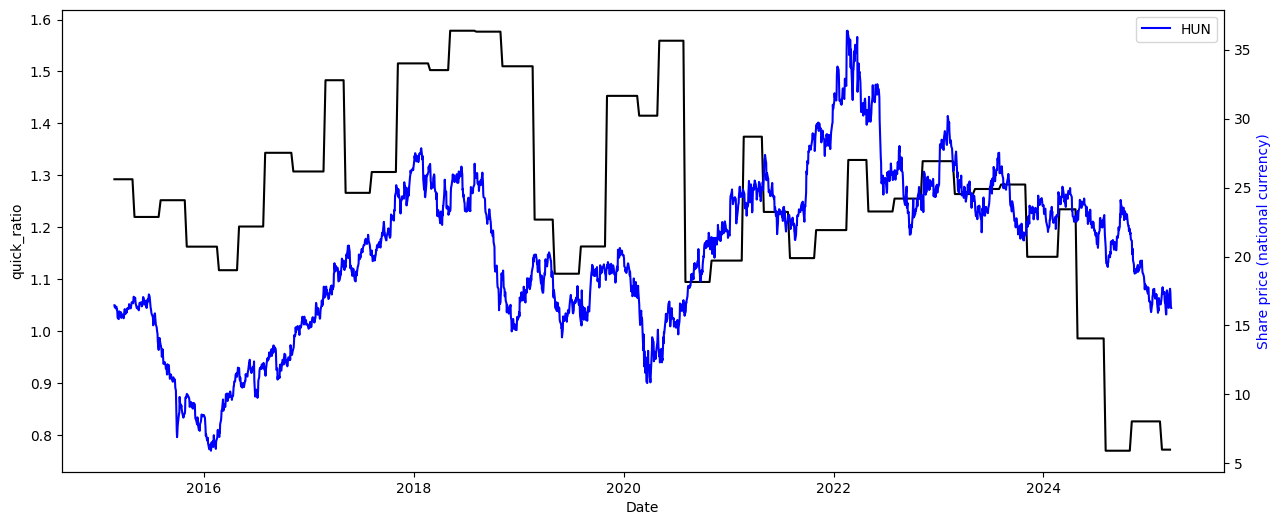

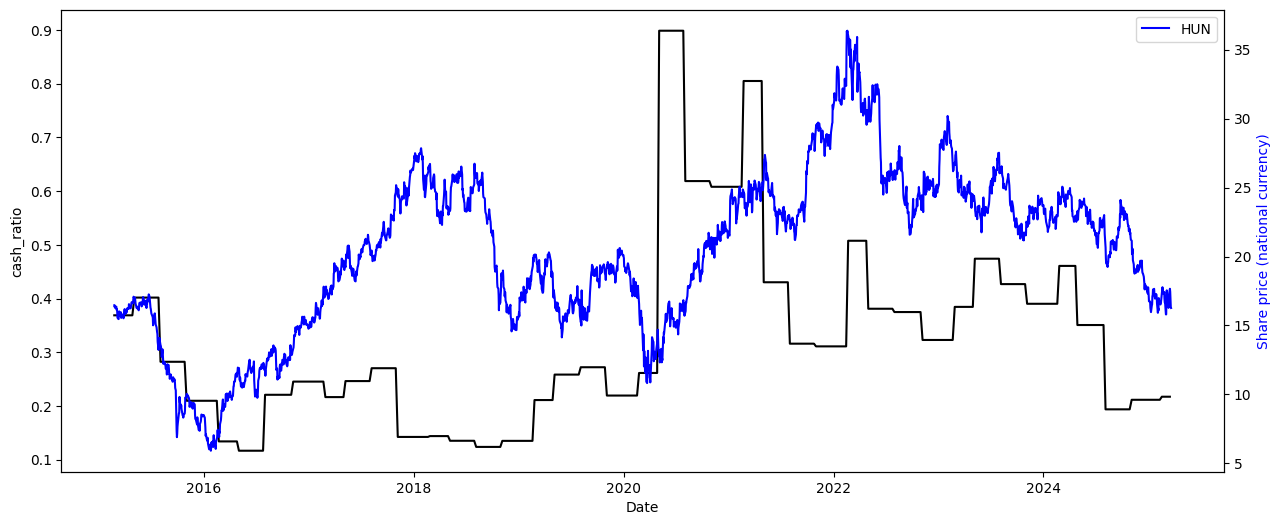

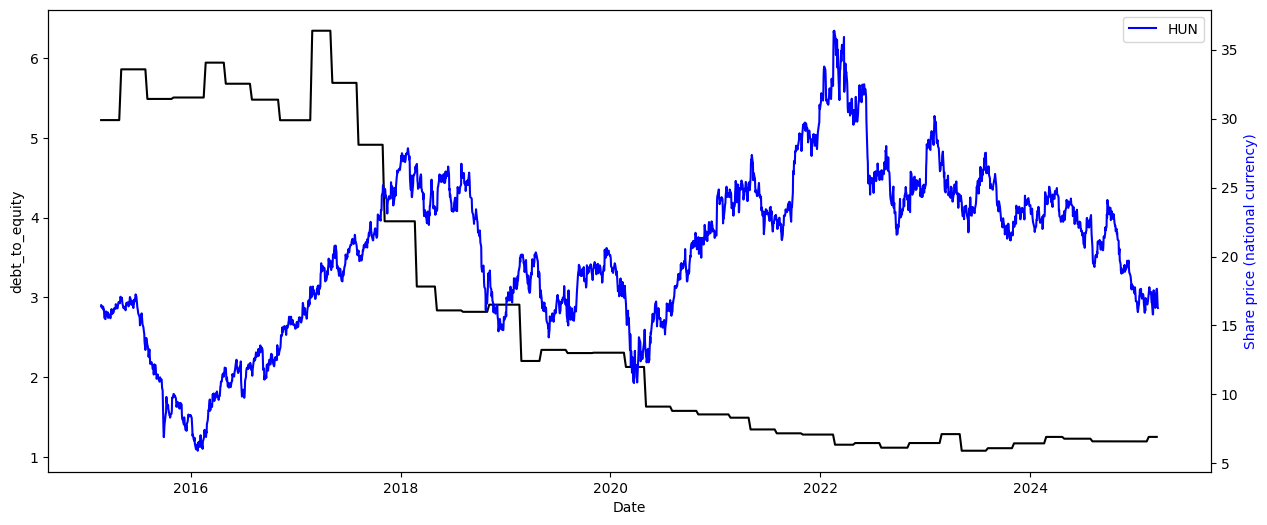

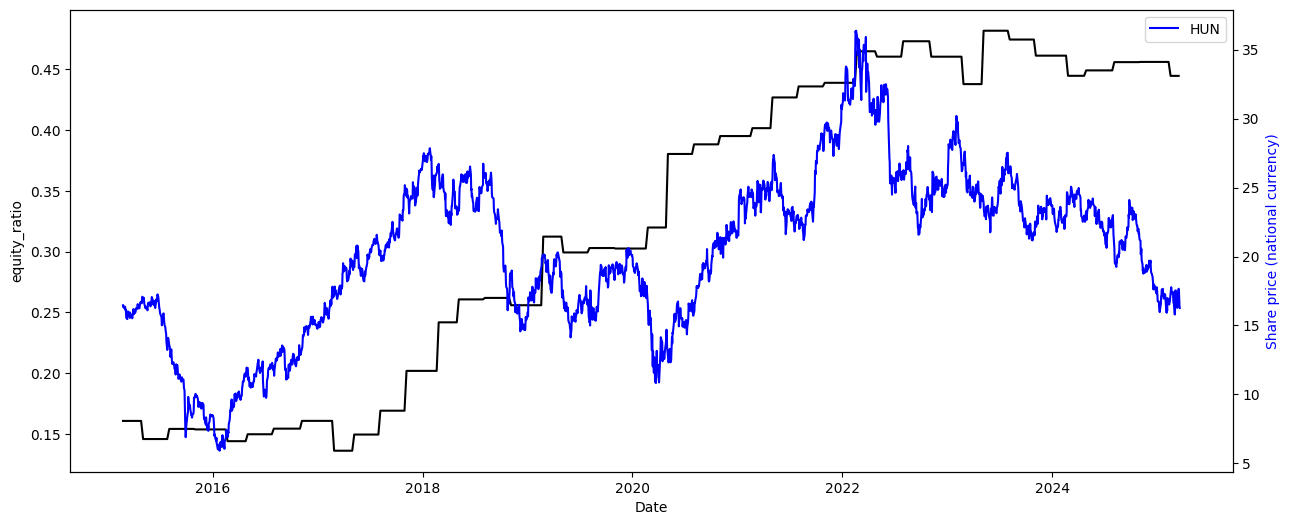

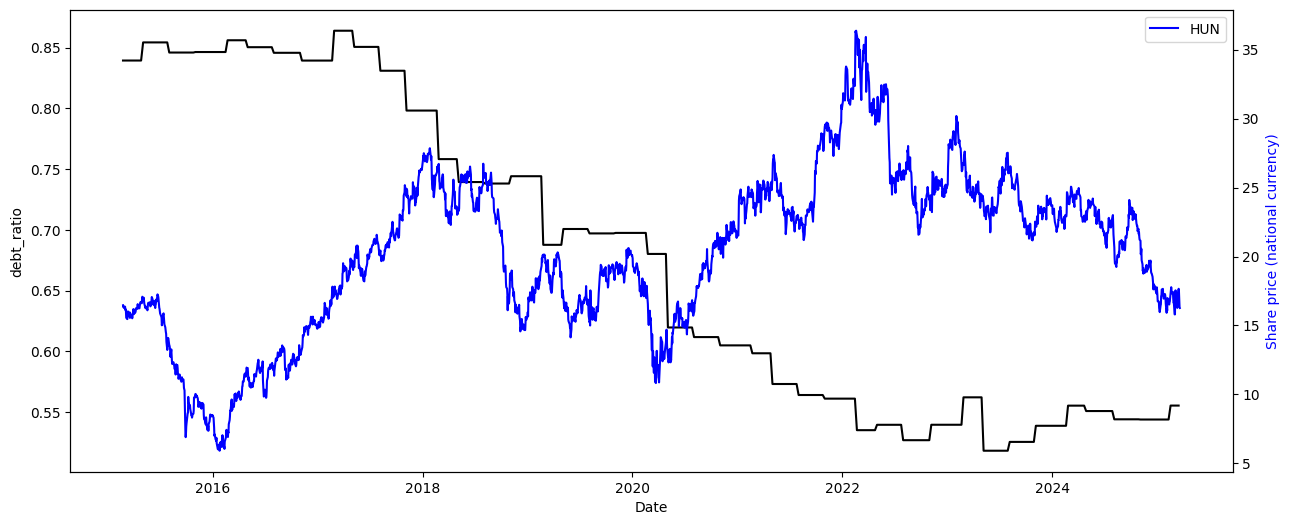

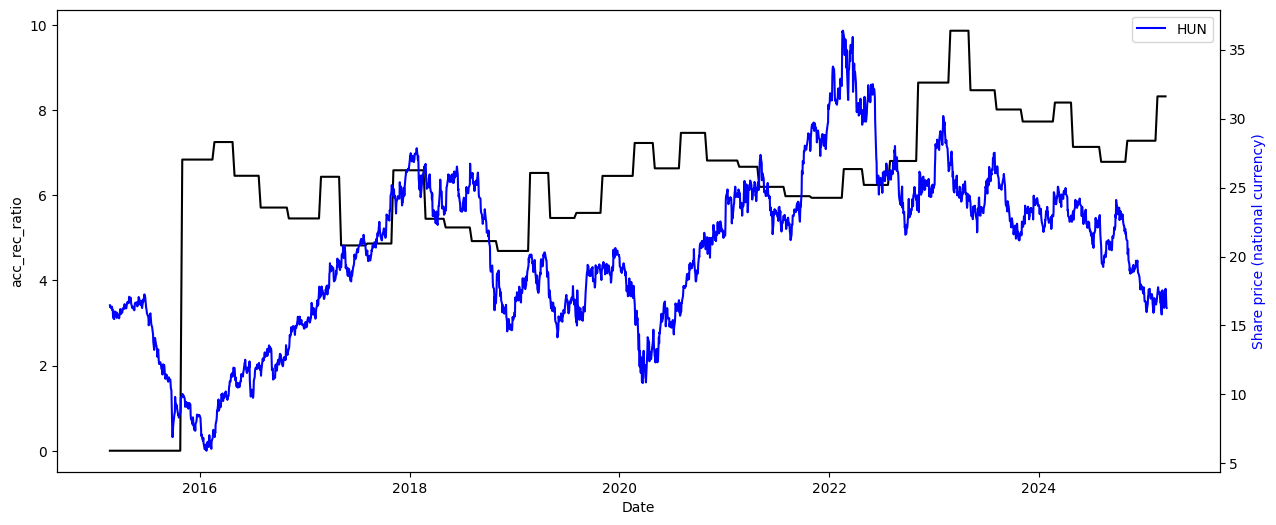

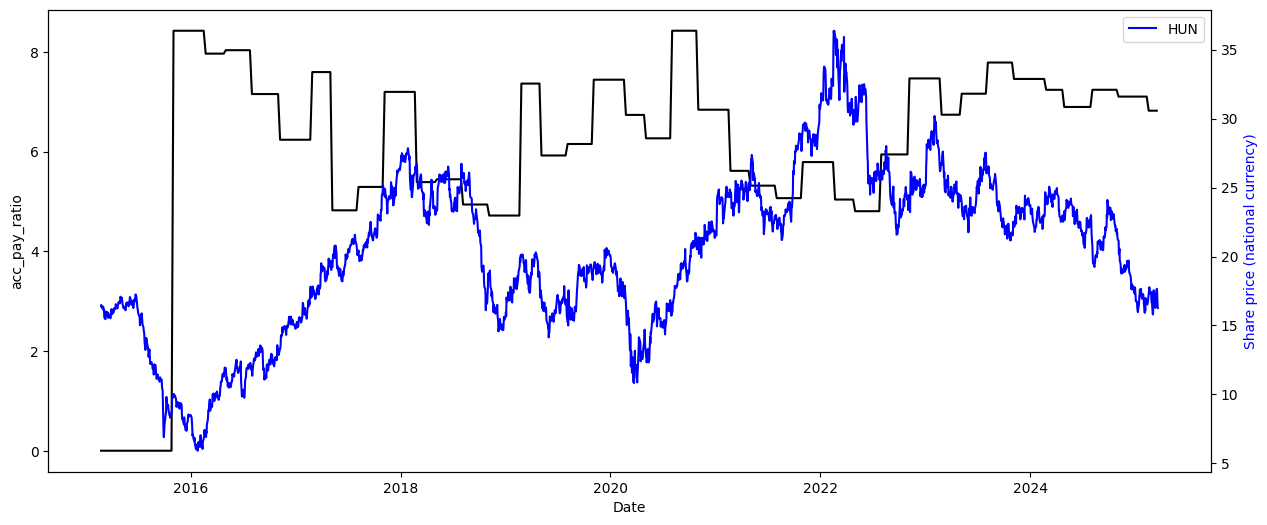

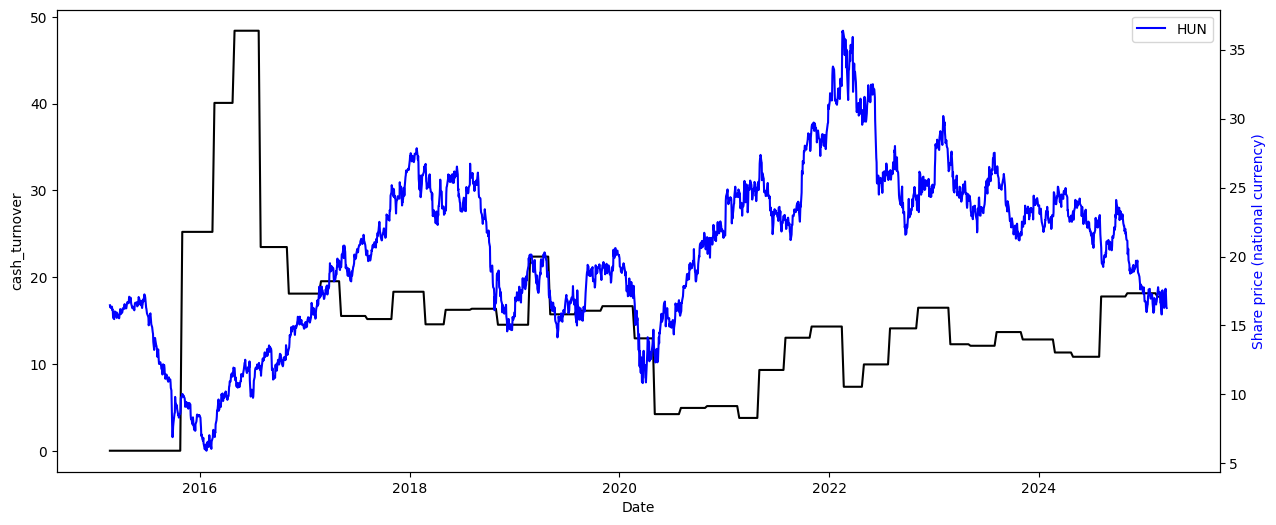

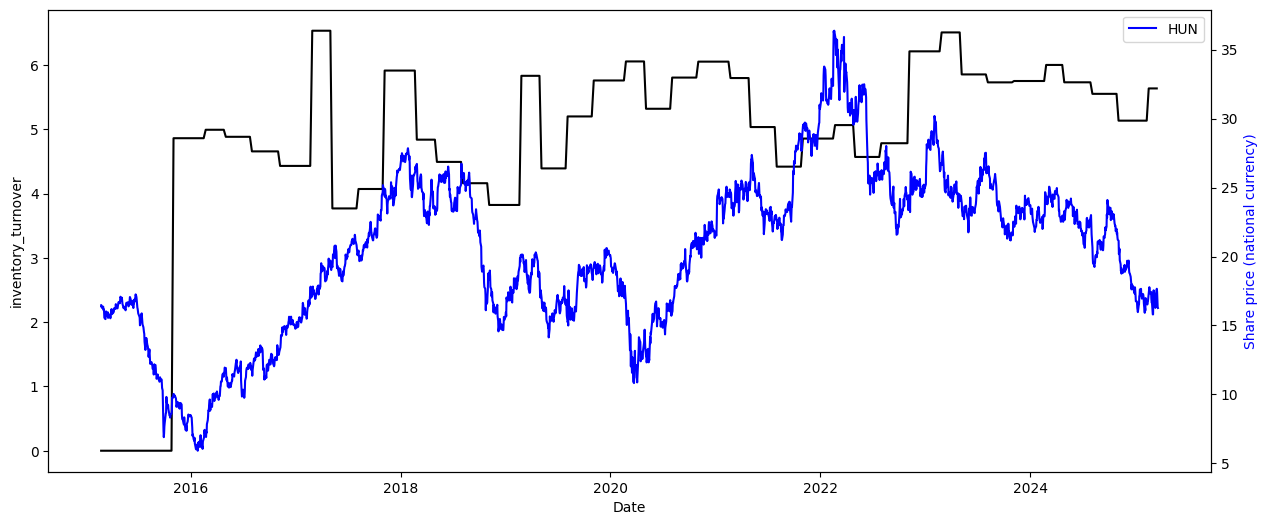

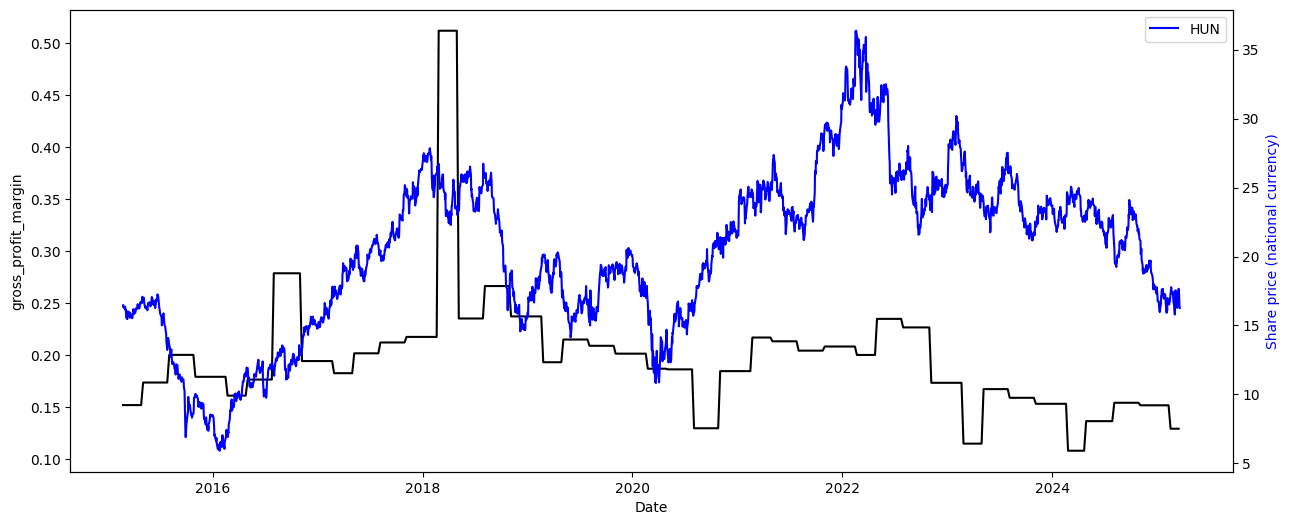

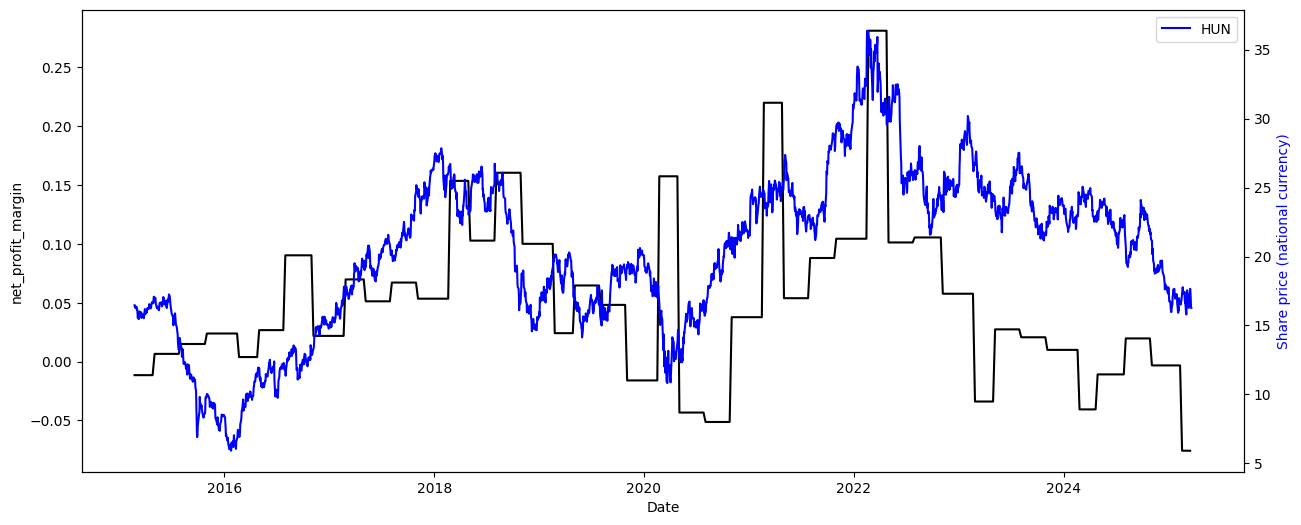

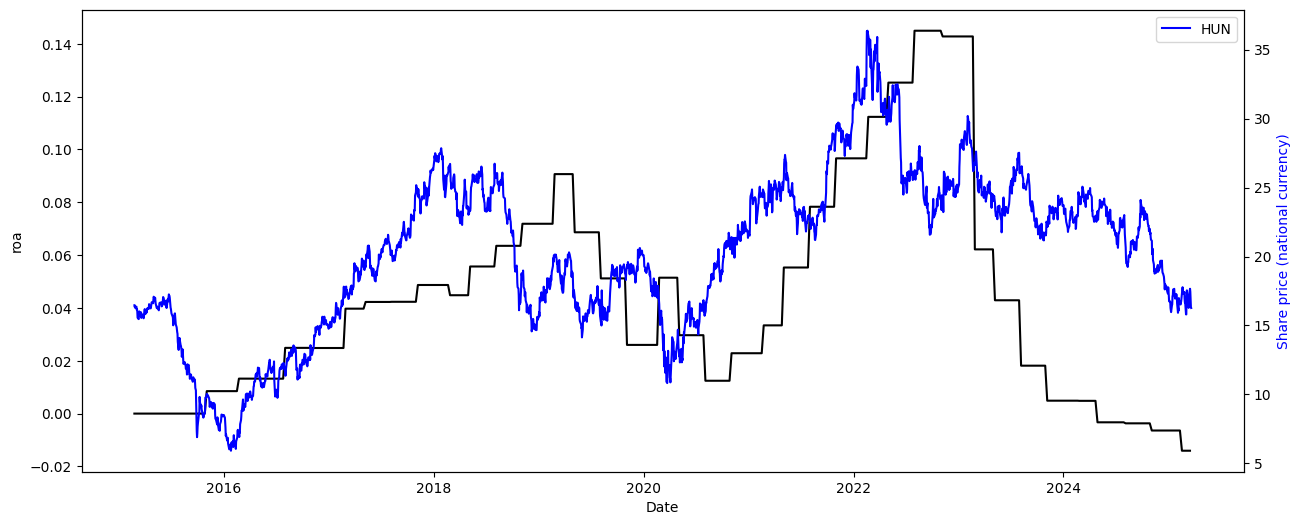

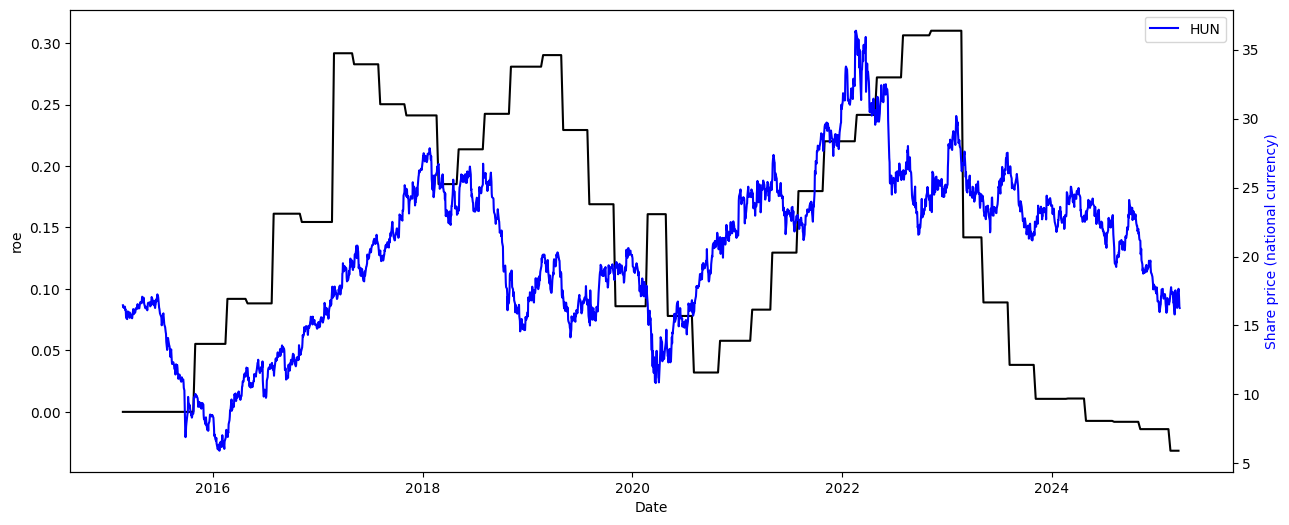

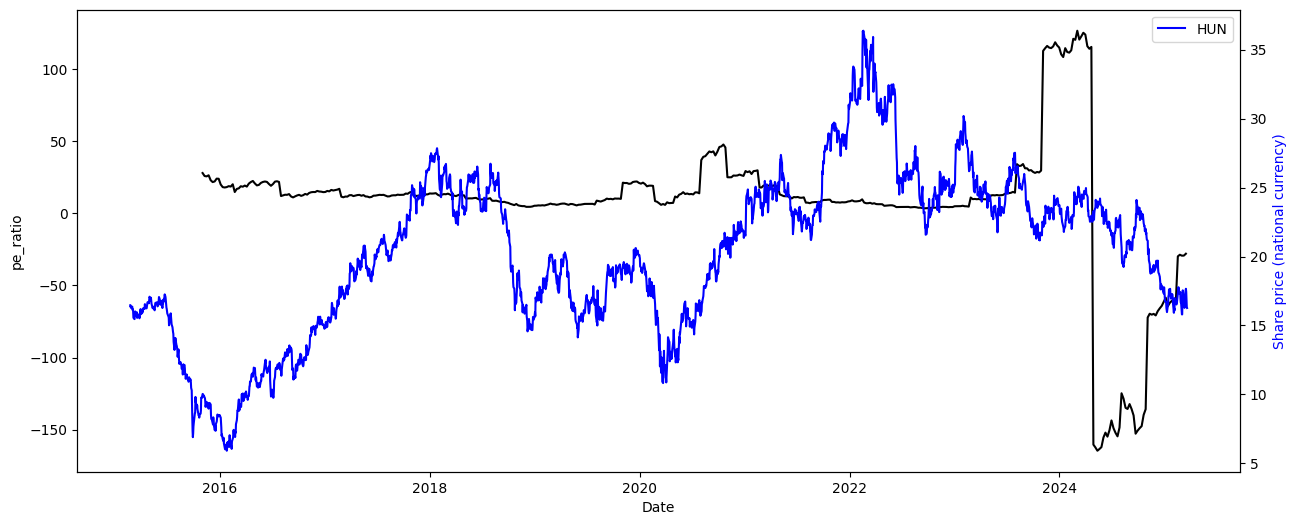

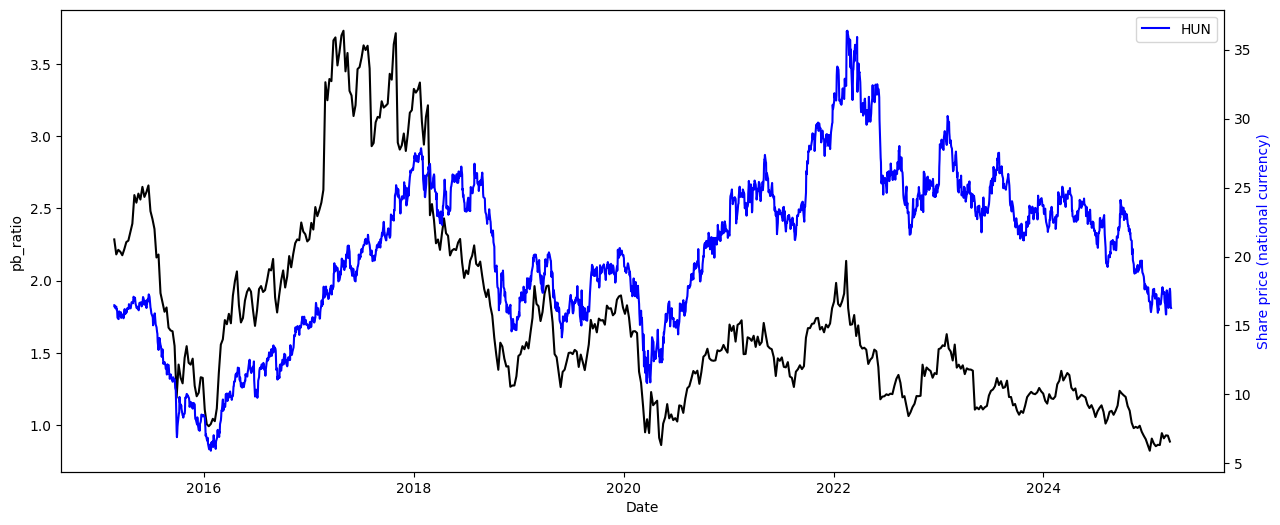

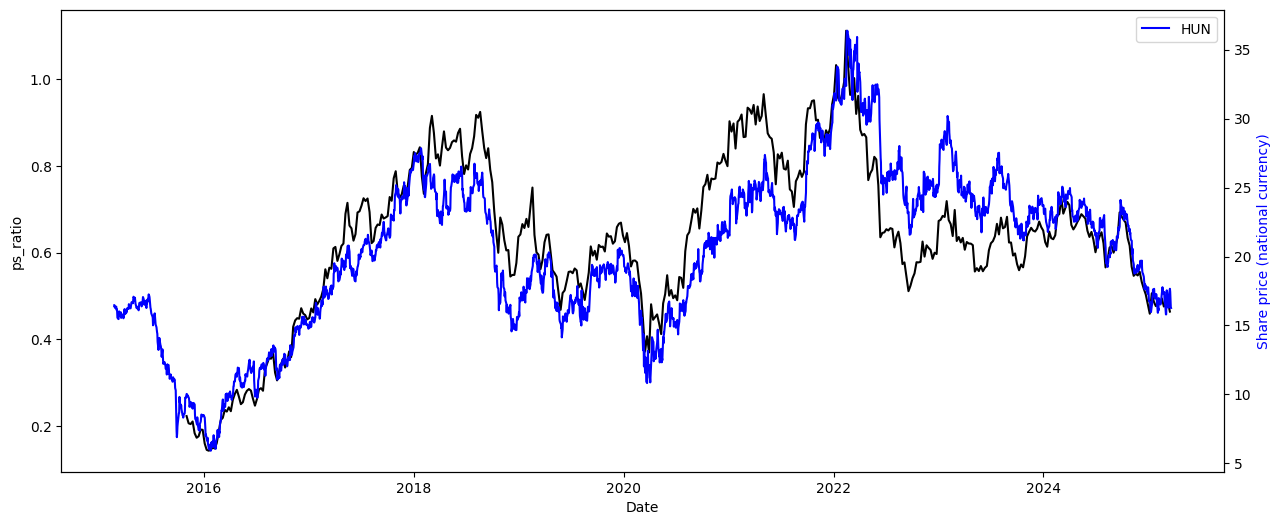

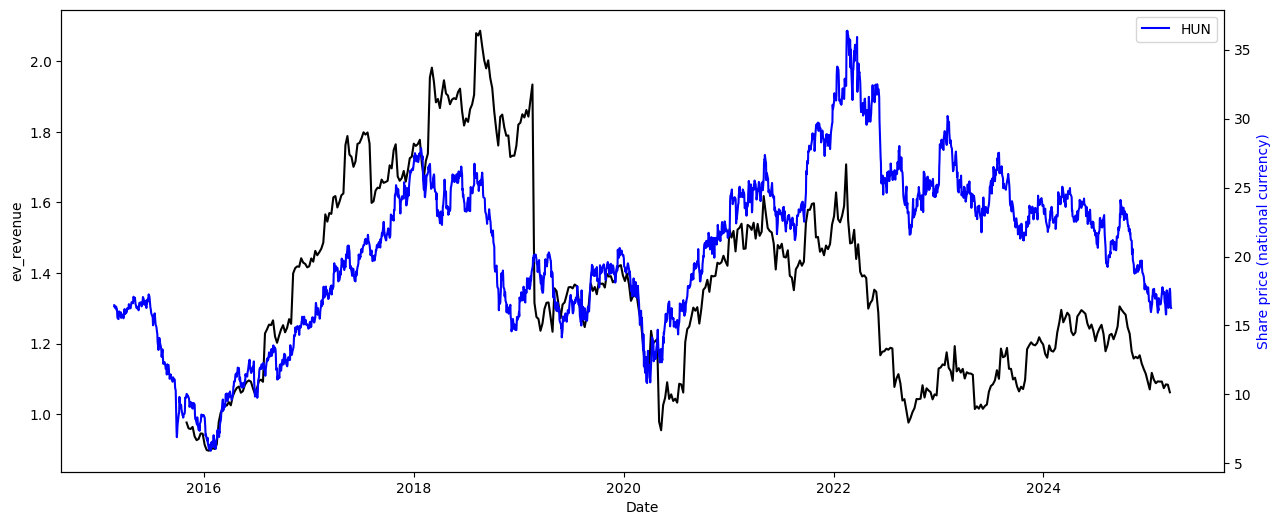

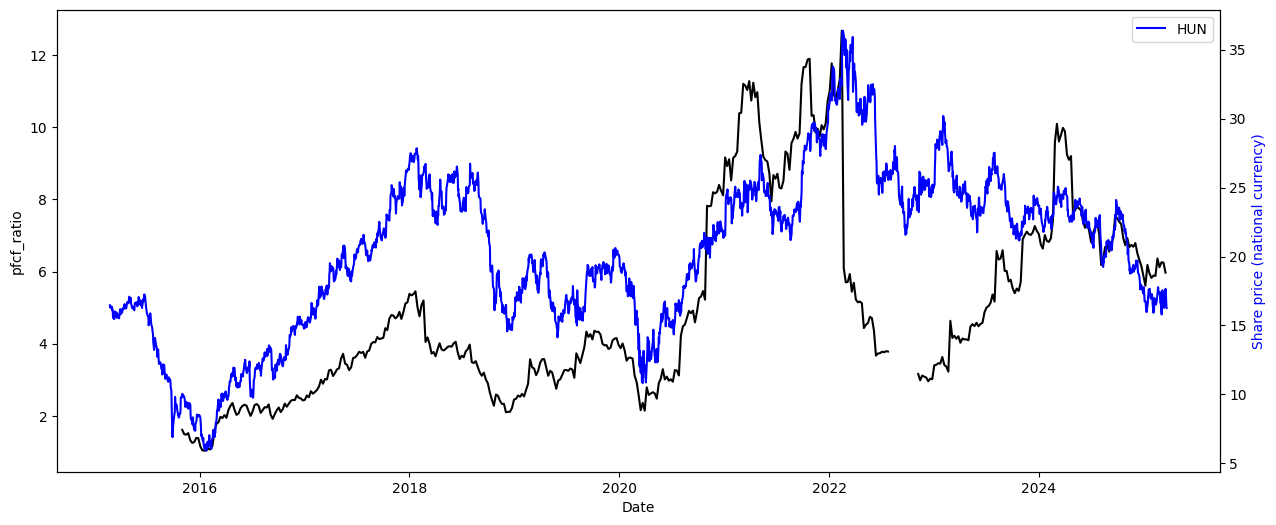

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

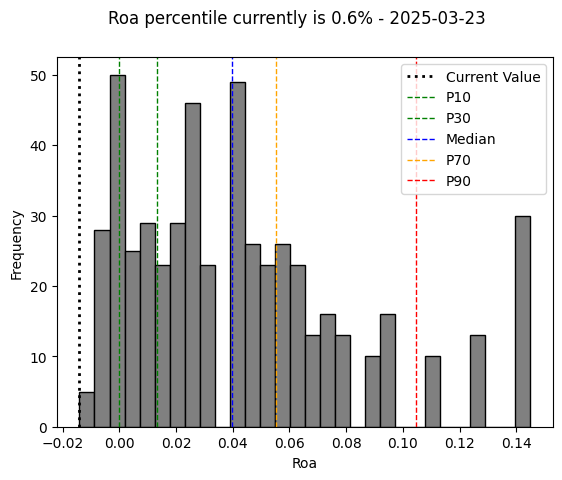

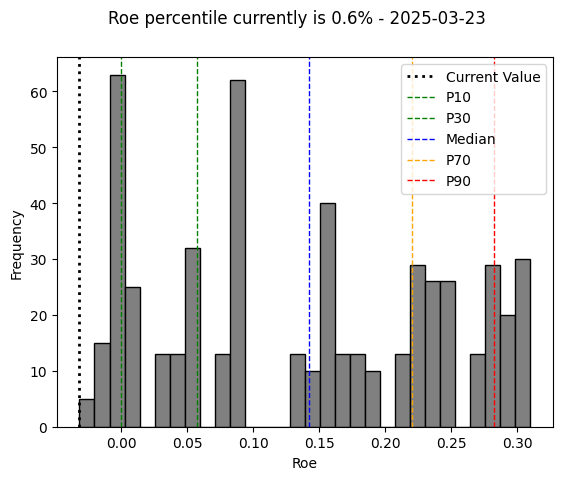

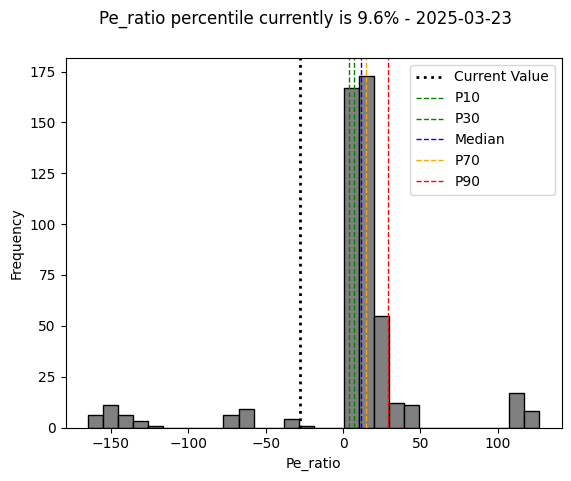

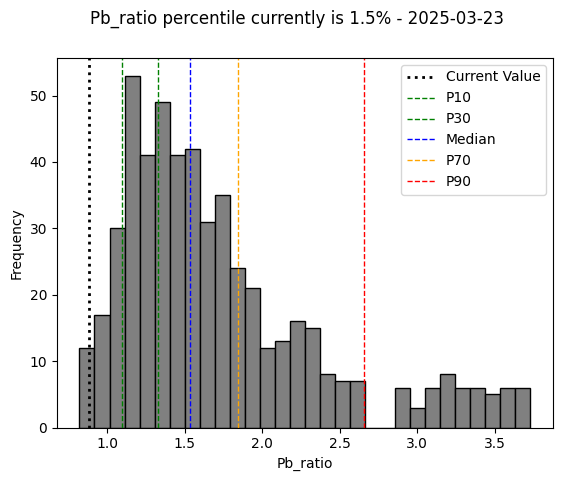

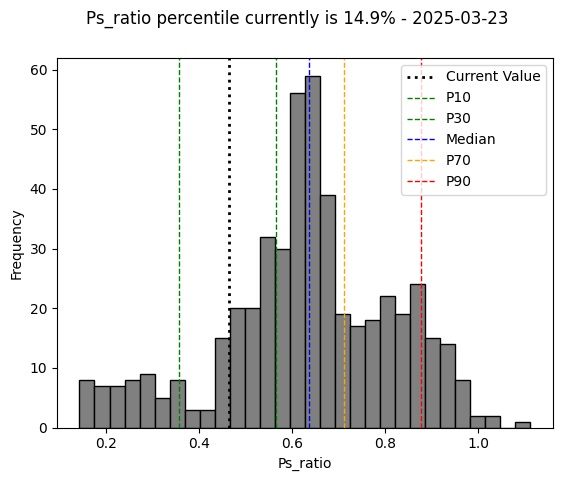

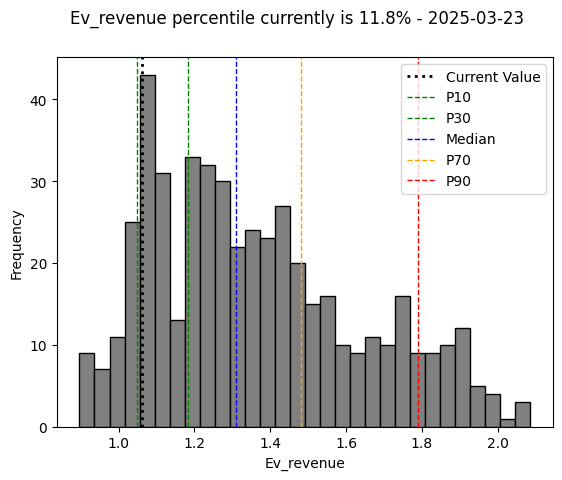

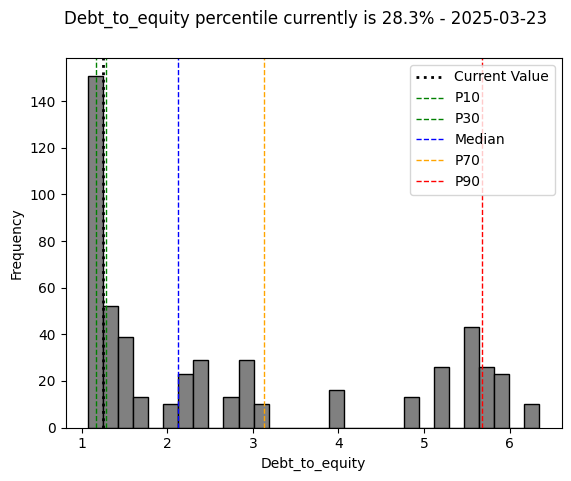

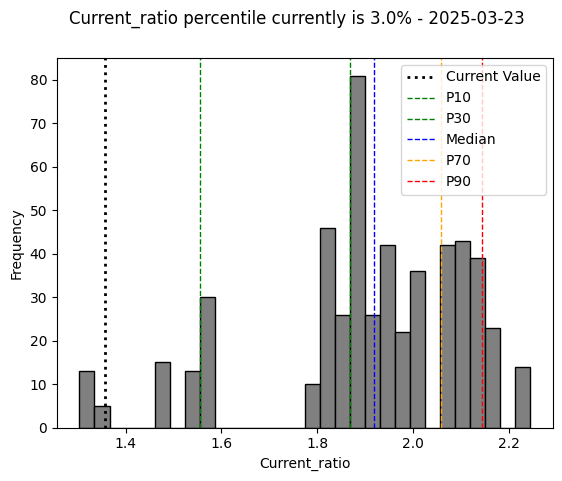

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.844052,0.097480,0.001044,0.346216,0.137894,-0.338906,0.198756
roe,0.844052,1.000000,0.131733,0.415389,0.242336,0.460168,0.047111,0.306859
pe_ratio,0.097480,0.131733,1.000000,0.147950,0.027297,0.042188,0.127383,0.514572
pb_ratio,0.001044,0.415389,0.147950,1.000000,0.202575,0.639048,0.664243,0.332378
ps_ratio,0.346216,0.242336,0.027297,0.202575,1.000000,0.645979,-0.501976,-0.282700
ev_revenue,0.137894,0.460168,0.042188,0.639048,0.645979,1.000000,0.193916,-0.037253
debt_to_equity,-0.338906,0.047111,0.127383,0.664243,-0.501976,0.193916,1.000000,0.512450
current_ratio,0.198756,0.306859,0.514572,0.332378,-0.282700,-0.037253,0.512450,1.000000


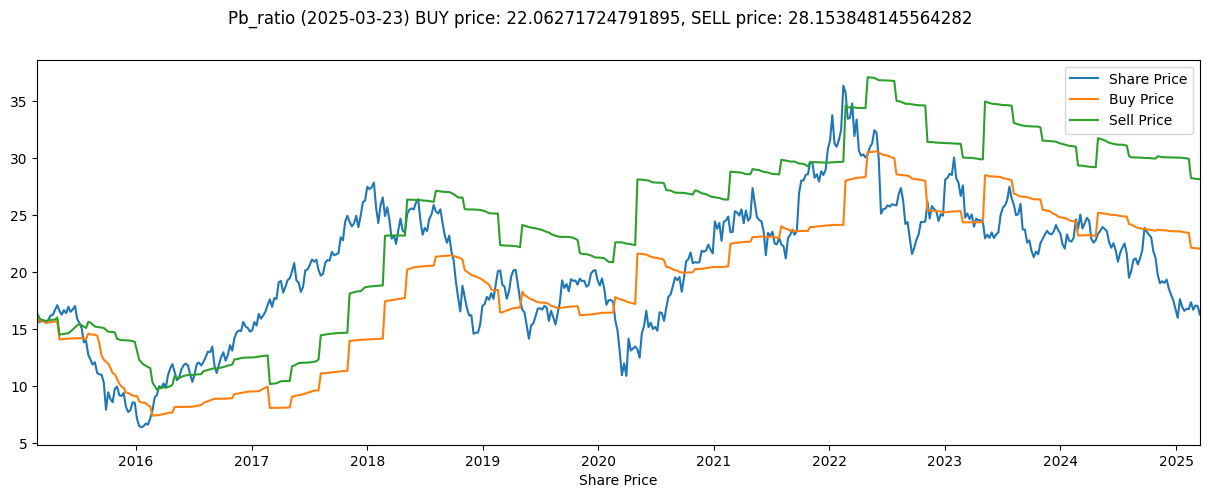

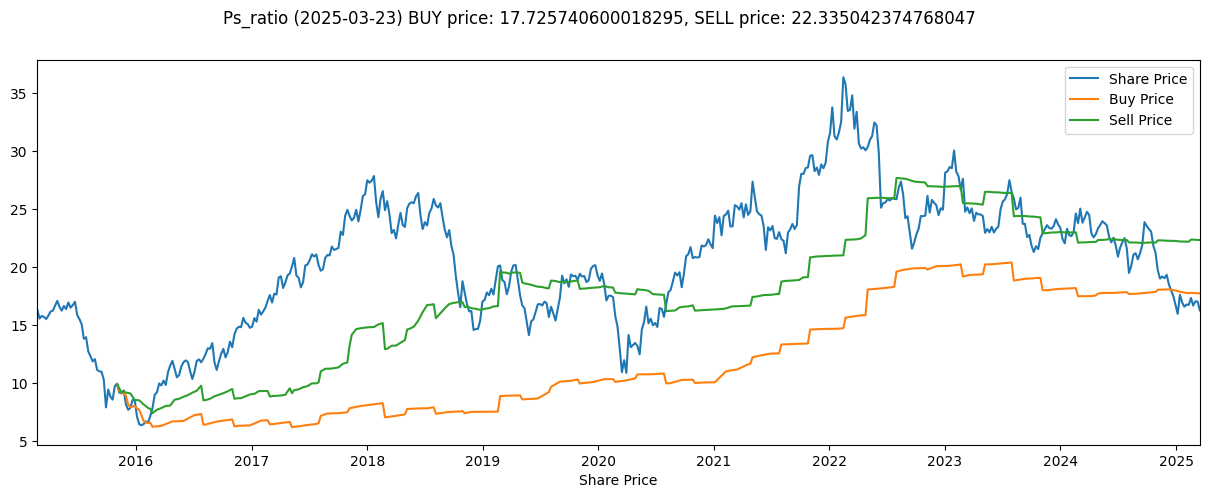

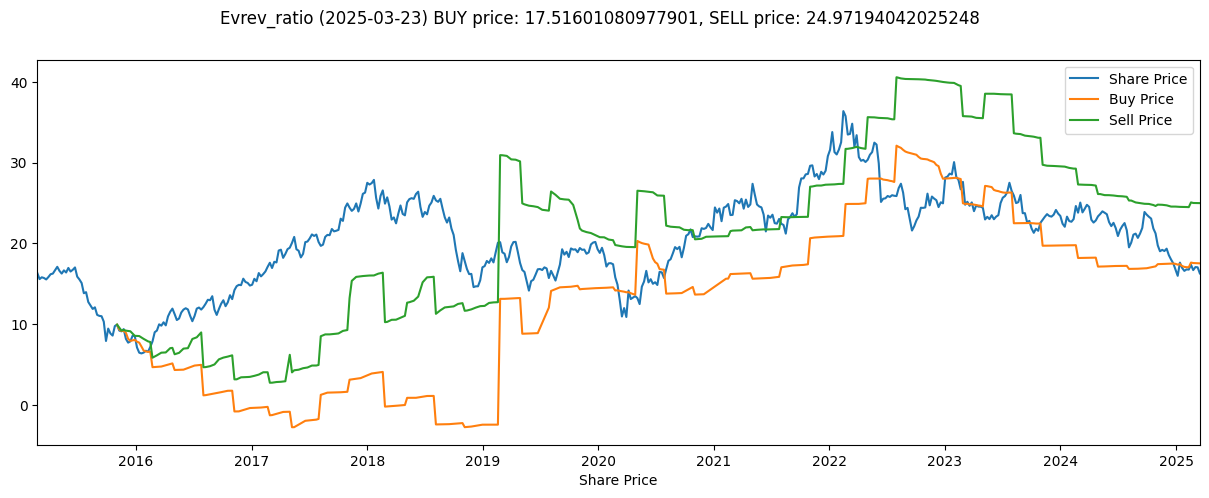

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)